# Project 1 TAA

In [2]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat

In [3]:
filename = "training_data_fear_neutral_happy.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

#number of training examples
m = len(X)
print(f"Loaded {X.shape[0]} traing examples, each with {X.shape[1]} features (pixels).")

Loaded 3000 traing examples, each with 2304 features (pixels).


### sigmoid function

In [4]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz=1/(1+np.exp(-z))
    
    return gz

In [5]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

### LeakyRelu function and gradient

In [6]:
def leaky_relu(z):
    """
    relu activation function
    """
    return np.where(z <=0, 0.01*z, z)

In [7]:
def leaky_relu_gradient(z):
    """
    computes the gradient of the leaky relu function
    """
    return np.where(z <=0, 0.01, 1)

In [8]:
def softmax(z):
    """
    compute softmax
    """
    e_x = np.exp(z - np.max(z))
    return e_x / e_x.sum(axis=0) 


### neural network cost function

In [163]:
def nnCostFunction(nn_params, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network (regularized and non regularized)
    """
    
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    layers=[]
    layers.append(X)
   
    #Forward Pass
    for i in range(len(nn_params)-1):
        a2 = sigmoid(layers[i] @ nn_params[i].T) # output layer
        a2 = np.hstack((np.ones((layers[i].shape[0],1)),a2 ))
        layers.append(a2)
        
    out = sigmoid(layers[-1] @ nn_params[-1].T)
    layers.append(out)
    
    #Expected Result for output layer
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        
    #Total sum of cost of all labels
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(layers[-1][:,j]) - (1-y10[:,j])*np.log(1-layers[-1][:,j]))
    
    cost = 1/m* J
    
    #Cost Regulized
    reg_term = 0
    for i in range(len(nn_params)):
        reg_term += np.sum(nn_params[i][:,1:]**2)
        
    reg_cost = cost + Lambda/(2*m) * reg_term
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grads = [np.zeros(Theta.shape) for Theta in nn_params ]
    
    #step 5 and 6
    for i in range(m):
        
        prev  = layers[-1][i,:] - y10[i,:] #step 4
        grads[-1] += prev.T[:,np.newaxis] @ layers[-2][i,:][:,np.newaxis].T 
        
        for j in reversed(range(0,len(layers)-2)):
            if j==2:
                prev = nn_params[j+1].T @ prev.T * sigmoidGradient(np.hstack((1,layers[j][i,:] @ nn_params[j].T)))
                grads[j]+= prev[1:][:,np.newaxis] @ layers[j][i,:][:,np.newaxis].T
            else:
                prev = nn_params[j+1].T @ prev[1:].T * sigmoidGradient(np.hstack((1,layers[j][i,:] @ nn_params[j].T)))
                grads[j]+= prev[1:][:,np.newaxis] @ layers[j][i,:][:,np.newaxis].T

    
    #step 7 
    grads = [1/m * grad for grad in grads]
    
    grads_reg = [grads[i] + (Lambda/m) * np.hstack((np.zeros((nn_params[i].shape[0],1)),nn_params[i][:,1:])) for i in range(len(nn_params)) ]
    
    return cost, nn_params, reg_cost, nn_params

In [217]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda, num_labels,regularized=False):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """

    nn_params =[i for i in initial_nn_params]
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        if regularized:
            cost, grads = nnCostFunction(nn_params, num_labels,X, y,Lambda)[2:]
        else:
            cost, grads = nnCostFunction(nn_params, num_labels,X, y,Lambda)[:2]
        nn_params = [nn_params[j] - (alpha * grads[j]) for j in range(len(nn_params))]
        J_history.append(cost)
    return nn_params , J_history

In [218]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [219]:

input_layer_size  = X.shape[1]
hidden_layer1_size = 144
hidden_layer2_size = 50
hidden_layer3_size = 30
num_labels = max(y)[0]+1

In [220]:
# Define algorithm properties
alpha=0.5 #learning rate
num_iters=10
Lambda=0.1

In [221]:
# Initialize thetas
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer1_size)
initial_Theta2 = randInitializeWeights(hidden_layer1_size, hidden_layer2_size)
initial_Theta3 = randInitializeWeights(hidden_layer2_size, hidden_layer3_size)
initial_Theta4 = randInitializeWeights(hidden_layer3_size, num_labels)

initial_nn_params =[]
initial_nn_params.append(initial_Theta1)
initial_nn_params.append(initial_Theta2)
initial_nn_params.append(initial_Theta3)
initial_nn_params.append(initial_Theta4)

# Gradient descent WITHOUT regularization
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda, num_labels)

# Gradient descent WITH regularization
nnTheta_reg, nnJ_history_reg = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda, num_labels, regularized=True)


### Analysis (Cost function by iterations)

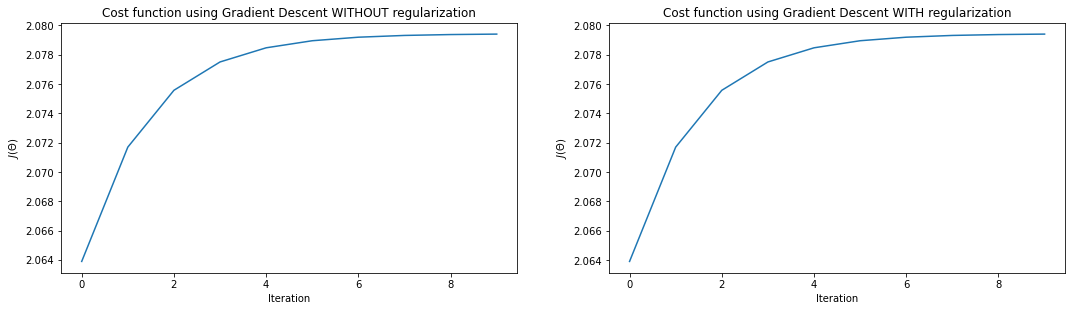

In [222]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(nnJ_history)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$J(\Theta)$")
axs[0].set_title("Cost function using Gradient Descent WITHOUT regularization")

axs[1].plot(nnJ_history_reg)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$J(\Theta)$")
axs[1].set_title("Cost function using Gradient Descent WITH regularization")

fig.set_size_inches(18, 4.6)

### Compute accuracy

In [223]:
def predict(Thetas, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m=X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)), X,axis=1)
    
    lt=X
    for i in range(len(Thetas)-1):
        z1= np.dot(lt,Thetas[i].T)
        a1= sigmoid(z1)
        a1 = np.append(np.ones((m,1)), a1,axis=1)
        lt=a1
    
    
    return np.argmax(lt,axis=1)+1

In [224]:
pred2 = predict(nnTheta, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/m*100,"%")

pred2_reg = predict(nnTheta_reg, X)
print("Training Set Accuracy (Regularized):",sum(pred2_reg[:,np.newaxis]==y)[0]/m*100,"%")

Training Set Accuracy: 33.33333333333333 %
Training Set Accuracy (Regularized): 33.33333333333333 %
